In [1]:
from __future__ import print_function

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from keras import backend as K
# assert len(backend.tensorflow_backend._get_available_gpus()) > 0

Using TensorFlow backend.


# Define the new cost function

## Mean squared error

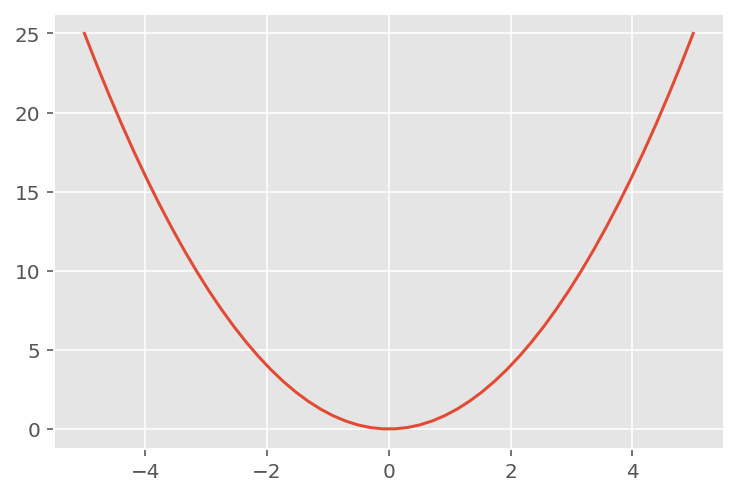

In [4]:
x = np.linspace(-5, 5)
plt.plot(x, x**2)

## Asymmetric mean squared error

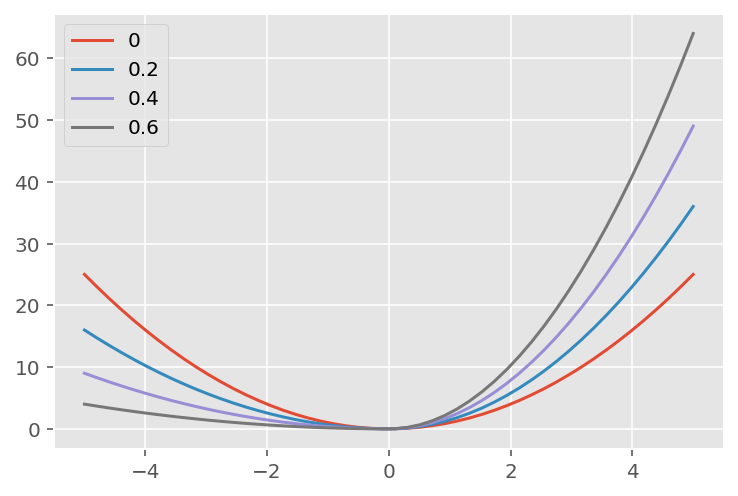

In [6]:
x = np.linspace(-5, 5)
plt.plot(x, (x**2) * ((np.sign(x)) ** 2), label="0")
plt.plot(x, (x**2) * ((np.sign(x) + 0.2) ** 2), label="0.2")
plt.plot(x, (x**2) * ((np.sign(x) + 0.4) ** 2), label="0.4")
plt.plot(x, (x**2) * ((np.sign(x) + 0.6) ** 2), label="0.6")
plt.legend()

In [6]:
def asymmetric_mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true) * K.square(K.sign(y_pred - y_true) + 0.6), axis=-1)

# Train the ANN and analyze results

In [7]:
costs = pd.read_csv("~/code/fifteen-puzzle/data/datasets/15-costs-v1.csv", nrows=400000)
costs.shape

(400000, 17)

In [8]:
costs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cost
0,13,4,7,15,8,0,2,1,9,6,10,14,3,12,5,11,56
1,10,2,4,12,3,13,8,0,1,5,6,7,14,9,11,15,34
2,8,15,11,14,13,5,6,7,4,9,12,0,1,2,10,3,59
3,1,0,10,6,2,3,14,8,9,7,4,13,5,11,12,15,43
4,1,5,6,8,3,4,9,14,11,10,2,12,13,15,0,7,41


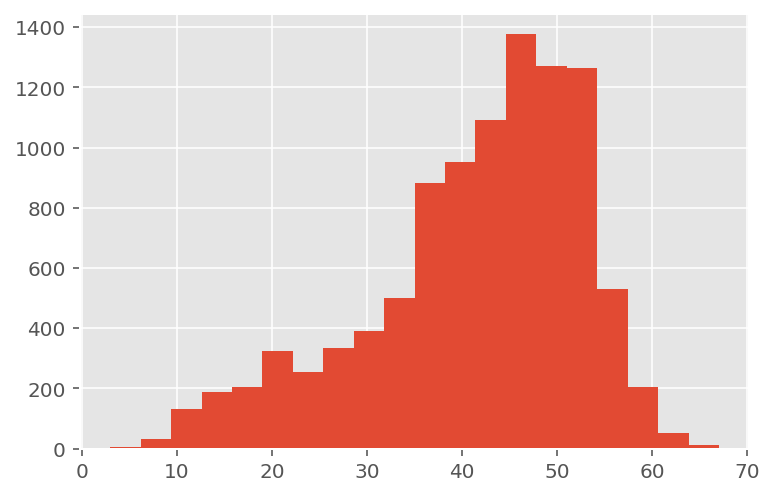

In [9]:
costs.sample(10000).cost.hist(bins=20);

In [10]:
X_raw = costs.iloc[:,:-1].values
y = costs['cost'].values

In [11]:
X = np.apply_along_axis(lambda x: np.eye(16)[x].ravel(), 1, X_raw)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
def get_model(layer_sizes, 
              learning_rate=0.001, 
              dropout_ratio=0.2, 
              activation='elu', 
              loss='mean_squared_error',
              kernel_initializer='he_normal', 
              batch_normalize=True):
    model = Sequential()
    model.add(Dense(layer_sizes[0], input_shape=(256,), activation=activation, kernel_initializer=kernel_initializer))
    model.add(Activation(activation))
    if batch_normalize:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_ratio))
    
    for layer_size in layer_sizes[1:]:
        model.add(Dense(layer_size, activation=activation, kernel_initializer=kernel_initializer))
        model.add(Activation(activation))
        if batch_normalize:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_ratio))

    model.add(Dense(1, kernel_initializer='he_normal'))
    model.compile(loss=loss,
                  optimizer=Adam(lr=learning_rate),
                  metrics=['accuracy'])
    return model

## MSE

In [2]:
model = get_model([1024, 1024, 512, 128, 64], 
                  learning_rate=0.01, 
                  dropout_ratio=0.2)

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=2,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

NameError: name 'get_model' is not defined

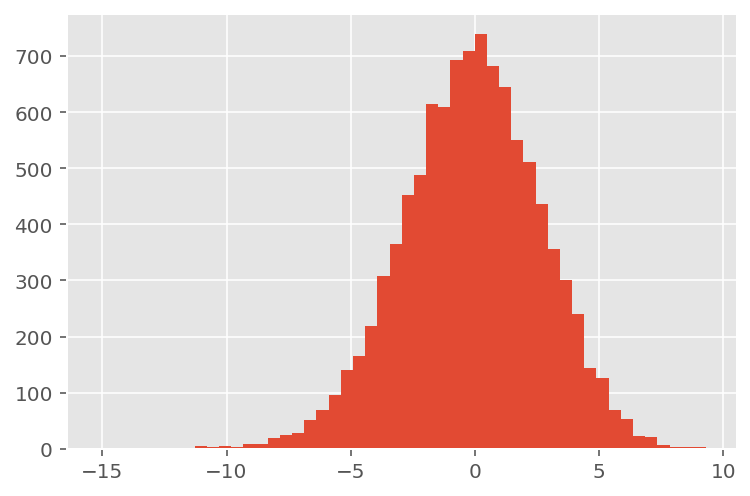

In [15]:
y_pred = model.predict(X_valid)
predictions = pd.DataFrame({'predicted': y_pred.flatten(), 'real': y_valid.flatten()})
predictions['difference'] = predictions['predicted'] - predictions['real']
predictions['difference'].sample(10000).hist(bins=50);

## AMSE

In [16]:
model = get_model([1024, 1024, 512, 128, 64], 
                  learning_rate=0.01, 
                  dropout_ratio=0.2,
                  loss=asymmetric_mean_squared_error)

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=2,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Train on 320000 samples, validate on 80000 samples
Epoch 1/2
320000/320000 [==============================] - 115s 359us/sample - loss: 15.6636 - acc: 0.0000e+00 - val_loss: 5.0232 - val_acc: 1.2500e-05
Epoch 2/2
320000/320000 [==============================] - 111s 346us/sample - loss: 6.2829 - acc: 3.1250e-06 - val_loss: 3.9583 - val_acc: 1.2500e-05


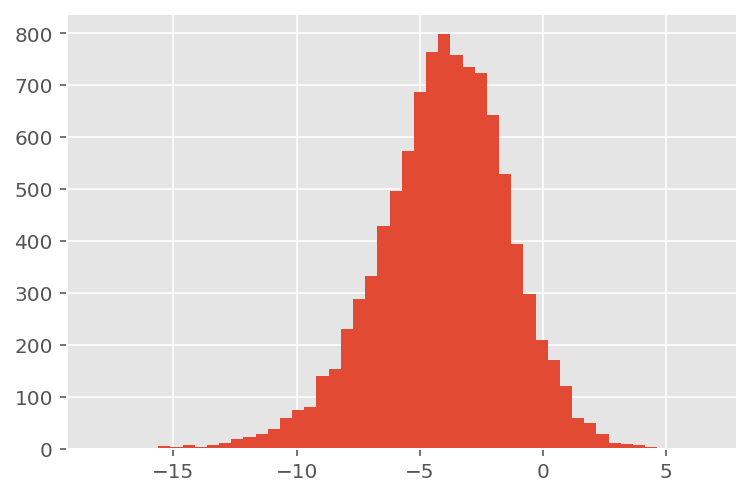

In [17]:
y_pred = model.predict(X_valid)
predictions = pd.DataFrame({'predicted': y_pred.flatten(), 'real': y_valid.flatten()})
predictions['difference'] = predictions['predicted'] - predictions['real']
predictions['difference'].sample(10000).hist(bins=50);